In [1]:
import numpy as np
import pandas as pd

from scipy import stats, special, spatial
from statsmodels.stats.multitest import multipletests
from statsmodels import robust
import importlib.util

import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings('ignore')


In [2]:
## datasets
folder = '../data/'

# Dataset random 1000bp subset

fn00 = 'dframe_shuffle_terminators_native.csv'
fn0 = 'dframe_shuffle_terminators_native_full.csv'
fn1 = 'dframe_shuffle_promoters_native_full.csv'

#fn1 = 'dframe_shuffle_terminators_gfp.csv'

# contains combinations with 1000 versions of native shuffled sequence
fn2 = 'dframe_native_terminators_random.csv' 
# contains combinations with 1000 versions of shuffled sequences from other genes
fn3 = 'dframe_shuffle_terminators_random.csv'

fn4 = 'scerevisiae.rsd1.lmbda_22.npz'
fn5 = 'scerevisiae.rsd1.saga'
fn6 = 'SGD_features.tab'

fn7 = 'df_Keren2013_predictions.csv'
fn8 = 'df_Yamanishi2013_predictions.csv'

fn10 = 'tmp_predictions_terminators_full.npy'
fn11 = 'tmp_predictions_promoters_full.npy'



In [3]:
## Temp stuff for exp

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def load_module(model_path):
    '''loads module containing models given path'''
    spec = importlib.util.spec_from_file_location('module',model_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

fname_module1 = folder+'Model_C3F2all.py'
module = load_module(fname_module1)

# load data
X_train, X_test, Y_train, Y_test = module.load_data(folder+fn4) 
Y = np.concatenate((Y_train, Y_test))

def load_gene_names(fname):
    npzfile = np.load(fname)
    names_train = npzfile['arr_6']
    names_test = npzfile['arr_7']
    return np.concatenate((names_train,names_test))

gene_names = load_gene_names(folder+fn4)

Y[np.where(gene_names == 'YOL086C')[0][0]]


Using TensorFlow backend.


array([27.232862], dtype=float32)

In [4]:
# get list of known strong and weak promoters
# http://www.yeastract.com/formorftogene.php
# Peng2015, Lee2015

strong = pd.DataFrame(['PGK1','TDH3','TEF1','YEF3','RPL3','ADH1'],columns=['gene_name'])
#' '.join(strong.values)

strong['gene_id'] = ['YCR012W',
'YGR192C',
'YPR080W',
'YLR249W',
'YOR063W',
'YOL086C']

weak = pd.DataFrame(['CYC1','CYC2','CYC3','TPS1','REV1','PSP2','RAD27','POP6'],columns=['gene_name'])
# ' '.join(weak)

weak['gene_id'] = ['YJR048W',
'YOR037W',
'YAL039C',
'YBR126C',
'YOR346W',
'YML017W',
'YKL113C',
'YGR030C']

# check which ones we have
print(strong[strong.gene_id.isin(gene_names)])
print(weak[weak.gene_id.isin(gene_names)])

strong['strength'] = 'strong'
weak['strength'] = 'weak'
df_known = strong[strong.gene_id.isin(gene_names)]
df_known = df_known.append(weak[weak.gene_id.isin(gene_names)]).reset_index(drop=True)

dfsaga = pd.read_csv(folder+fn5)
df_known['type'] = dfsaga.set_index('gene_id').loc[df_known.gene_id].group.values

df_known

  gene_name  gene_id
0      PGK1  YCR012W
1      TDH3  YGR192C
2      TEF1  YPR080W
3      YEF3  YLR249W
4      RPL3  YOR063W
5      ADH1  YOL086C
  gene_name  gene_id
1      CYC2  YOR037W
2      CYC3  YAL039C
4      REV1  YOR346W
5      PSP2  YML017W
6     RAD27  YKL113C
7      POP6  YGR030C


,gene_name,gene_id,strength,type
0,PGK1,YCR012W,strong,SAGA-dominated
1,TDH3,YGR192C,strong,SAGA-dominated
2,TEF1,YPR080W,strong,TFIID-dominated
3,YEF3,YLR249W,strong,TFIID-dominated
4,RPL3,YOR063W,strong,TFIID-dominated
5,ADH1,YOL086C,strong,SAGA-dominated
6,CYC2,YOR037W,weak,TFIID-dominated
7,CYC3,YAL039C,weak,TFIID-dominated
8,REV1,YOR346W,weak,TFIID-dominated
9,PSP2,YML017W,weak,no call


# Native promoters - shuffled terminators

In [59]:
# load data

df_native = pd.read_csv(folder+fn0,sep=';')
df_native.head()

,gene_id_left,gene_id_right,ypred,ynative,ytpm,ynative_tpm,yfold,yfold_tpm
0,YOL097W-A,YLR312W-A,4.887,1.125977,27.609955,2.734563,4.339983,10.096662
1,YOL097W-A,YMR187C,3.229,1.125977,11.465391,2.734563,2.867303,4.192769
2,YOL097W-A,YER183C,5.180,1.125977,31.728413,2.734563,4.600173,11.602736
3,YOL097W-A,YFR022W,2.889,1.125977,9.357251,2.734563,2.565481,3.421845
4,YOL097W-A,YNL233W,2.850,1.125977,9.135835,2.734563,2.530789,3.340876


In [60]:
# mark all important points on figure

# check gene function
# wget file from sgd
# import wget
# url = 'https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab'
# fname = wget.download(url)

columns = ['Primary SGDID (mandatory)',
           'Feature type (mandatory)',
            'Feature qualifier (optional)',
            'Feature name',
            'Standard gene name (optional)',
            'Alias (optional, multiples separated by |)',
            'Parent feature name (optional)',
            'Secondary SGDID (optional, multiples separated by |)',
            'Chromosome (optional)',
            'Start_coordinate (optional)',
            'Stop_coordinate (optional)',
            'Strand (optional)',
            'Genetic position (optional)',
            'Coordinate version (optional)',
            'Sequence version (optional)',
            'Description']
gene_function = pd.read_csv(folder+fn6,sep='\t',header=None,names=columns)
gene_function.head()

# max range is same as max increase
max_range = df_native.groupby('gene_id_left').yfold_tpm.apply(lambda x: max(x)/min(x)).max()
print(df_native[df_native.yfold_tpm==max_range][['gene_id_left','yfold_tpm']])

# from gene to max point
# maximum increase
max_increase = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                .max().max()]
                .index.values[0])
print(df_native.loc[max_increase])

# get gene name
name_increase = (pd.DataFrame(df_native.loc[max_increase]).transpose()
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
).gene_id_left.values[0]
print(name_increase)

# max decrease
max_decrease = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                .min().min()]
                .index.values[0])
print(df_native.loc[max_decrease])

# get gene name
name_decrease = (pd.DataFrame(df_native.loc[max_decrease]).transpose()
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
)['Standard gene name (optional)'].values[0]
print(name_decrease)

# average on both sides
print((df_native.groupby('gene_id_left')['yfold_tpm']
 .max().median()+1/df_native.groupby('gene_id_left')['yfold_tpm']
                   .min().median())/2)

     gene_id_left  yfold_tpm
1019    YOL097W-A  130.16818
gene_id_left     YOL097W-A
gene_id_right      YGR192C
ypred                12.01
ynative            1.12598
ytpm               355.953
ynative_tpm        2.73456
yfold              10.6644
yfold_tpm          130.168
Name: 1019, dtype: object
YOL097W-A
gene_id_left     YHR005C-A
gene_id_right      YLR234W
ypred                3.586
ynative            10.0312
ytpm               14.0645
ynative_tpm        199.698
yfold             0.357477
yfold_tpm        0.0704292
Name: 15229577, dtype: object
TIM10
2.873308859768355


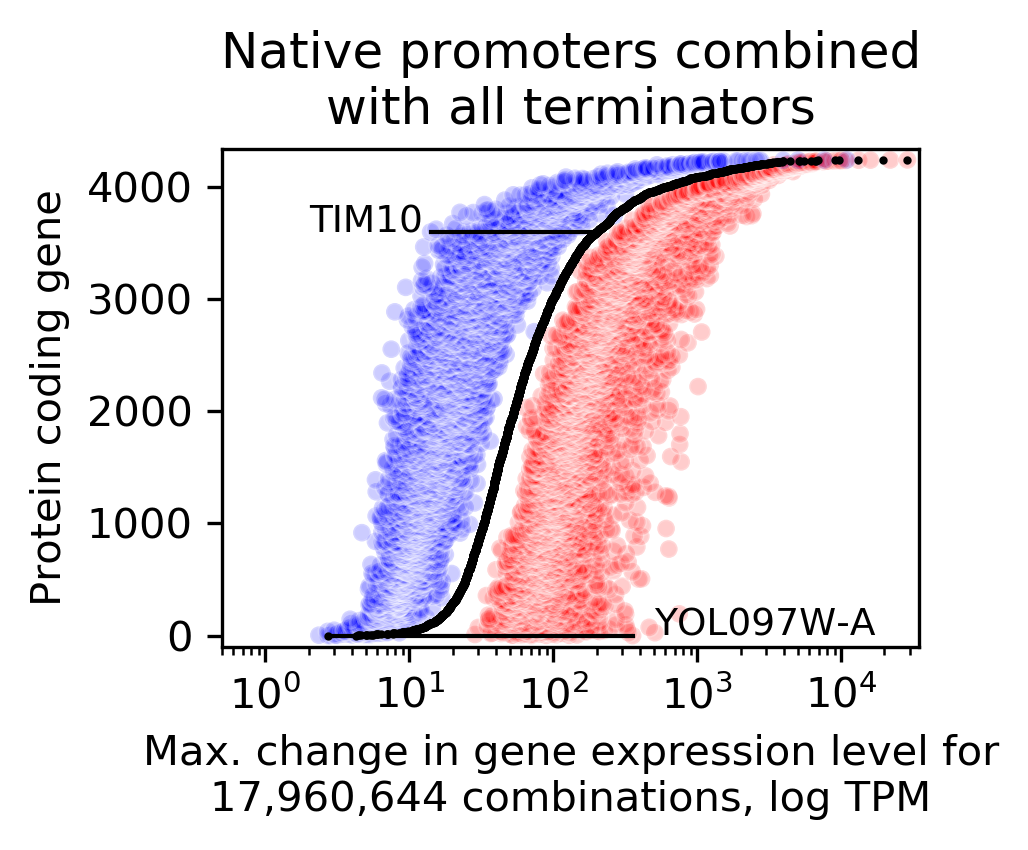

In [61]:
## Plot maximum values per gene

df_plot = (df_native
           .groupby('gene_id_left')['ytpm']
           .max()
           .reset_index()
           .rename(columns={'ytpm':'ytpm_max'})
          )
df_plot['ytpm_min'] = df_native.groupby('gene_id_left')['ytpm'].min().values
df_plot['ytpm'] = df_native.groupby('gene_id_left').ynative_tpm.mean().values
df_plot = df_plot.sort_values(by='ytpm')

df_plot.head()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))

plt.scatter(df_plot.ytpm,
            df_plot.gene_id_left,
            s=1,alpha=1,zorder=10, color='k')
#ax = sns.scatterplot(x='gene_id_left',y='ytpm',alpha=1,data=df_plot)
ax = sns.scatterplot(y='gene_id_left',x='ytpm_max',
                     size=1,alpha=0.2,data=df_plot,
                     color='r',legend=False)
ax = sns.scatterplot(y='gene_id_left',x='ytpm_min',
                     size=1,alpha=0.2,data=df_plot,
                     color='b',legend=False)
plt.title('Native promoters combined\nwith all terminators')
plt.xscale('log')
plt.yticks(ticks=[0,1000,2000,3000,4000],labels=[0,1000,2000,3000,4000])
#plt.xlim(1e0,1e4)
plt.xlim(1-1/2,10000+25000)
plt.ylim(-100,len(gene_names)+100)
plt.xlabel('Max. change in gene expression level for\n17,960,644 combinations, log TPM')
plt.ylabel('Protein coding gene')
#plt.legend(['native', 'max', 'min'],
#          bbox_to_anchor=(1.5, 1.5))

# mark stuff
# from gene to max point
# maximum increase
index = int(np.floor(max_increase/df_native.gene_id_left.unique().shape[0]))
plt.plot([df_native.loc[max_increase].ynative_tpm,
         df_native.loc[max_increase].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_increase,xy=(500,index),fontsize=9)

index = int(np.floor(max_decrease/df_native.gene_id_left.unique().shape[0]))
plt.plot([df_native.loc[max_decrease].ynative_tpm,
         df_native.loc[max_decrease].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_decrease,xy=(2,index),fontsize=9)

# max range is same as max increase

plt.savefig('f5b.svg')

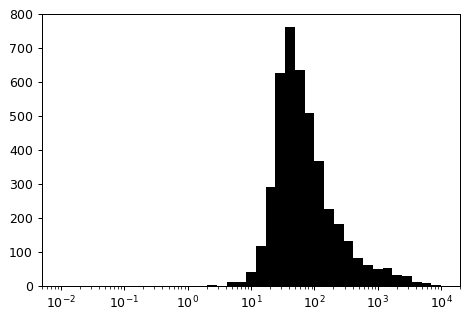

In [62]:
# distribution of predicted native y

mpl.rcParams['figure.dpi'] = 90
#plt.figure(figsize=(2,1.5))
#var.hist(bins = 100)
bmin, bmax = 0.01, 10000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(df_plot.ytpm, bins = logbins,color='k')
plt.xscale('log')
plt.show()

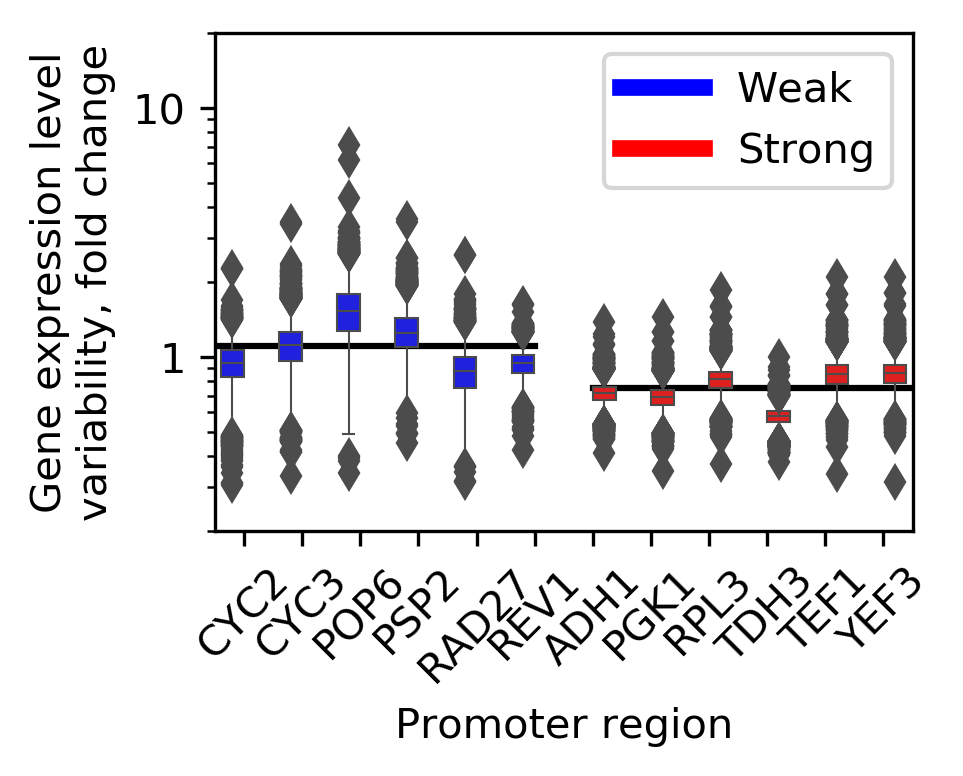

In [63]:
# Strong and weak promoter subsets

## analyse known genes changes
df_plot = (df_native[df_native.gene_id_left.isin(df_known.gene_id)]
           .merge(df_known,left_on='gene_id_left',right_on='gene_id',how='left')
          )

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))

sns.boxplot(x='gene_name',y='yfold_tpm',data=df_plot,
            hue='strength',palette=['b','r'],
            order=df_plot.sort_values(by=['strength','gene_name'],ascending=[False,True])
            .gene_name.unique(),
            linewidth=0.5)
ann = df_plot.groupby(['strength','gene_name']).yfold_tpm.median().loc['weak'].mean()
plt.plot([-0.5,5],[ann,ann],'k',zorder=0)
ann = df_plot.groupby(['strength','gene_name']).yfold_tpm.median().loc['strong'].mean()
plt.plot([6,11.5],[ann,ann],'k',zorder=0)
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('Gene expression level\nvariability, fold change')
plt.xlabel('Promoter region')
plt.ylim(0.2,20)
plt.yticks(ticks=[1,10],labels=['1','10'])

# legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
plt.legend(custom_lines, ['Weak',
                         'Strong'])

plt.savefig('f5c.svg')

In [64]:
tmp = df_plot.query("strength=='weak'")
print(tmp[tmp.yfold_tpm==tmp.yfold_tpm.max()])

tmp = df_plot.query("strength=='strong'")
print(tmp[tmp.yfold_tpm==tmp.yfold_tpm.min()])

df_plot.groupby(['strength','gene_name']).yfold_tpm.median().reset_index().groupby('strength').mean()

     gene_id_left gene_id_right  ypred   ynative       ytpm  ynative_tpm  \
1013      YGR030C       YGR192C   9.25  4.414062  155.46422    21.856396   

         yfold  yfold_tpm gene_name  gene_id strength             type  
1013  2.095575   7.112985      POP6  YGR030C     weak  TFIID-dominated  
      gene_id_left gene_id_right   ypred    ynative      ytpm  ynative_tpm  \
31073      YLR249W       YOR133W  15.625  21.453125  874.0535    2770.7756   

          yfold  yfold_tpm gene_name  gene_id strength             type  
31073  0.728332   0.315454      YEF3  YLR249W   strong  TFIID-dominated  


,yfold_tpm
strength,
strong,0.753567
weak,1.111332


In [65]:
# Top 100 Bottom 100

df_100 = df_native.sort_values(by='ynative_tpm').iloc[:100*4238]
df_100['strength'] = 'weak'
# sanity check
# tmp.groupby('gene_id_left').gene_id_right.count().describe()
print(df_100.shape)


tmp = df_native.sort_values(by='ynative_tpm').iloc[-100*4238:]
tmp['strength'] = 'strong'
# sanity check
# tmp.groupby('gene_id_left').gene_id_right.count().describe()

df_100 = df_100.append(tmp)
df_100['region'] = 'promoter'
print(df_100.shape)

(423800, 9)
(847600, 10)


2.0256107
1.3405210283512154
RanksumsResult(statistic=-797.2353324739493, pvalue=0.0)
RanksumsResult(statistic=-797.3075002788353, pvalue=0.0)


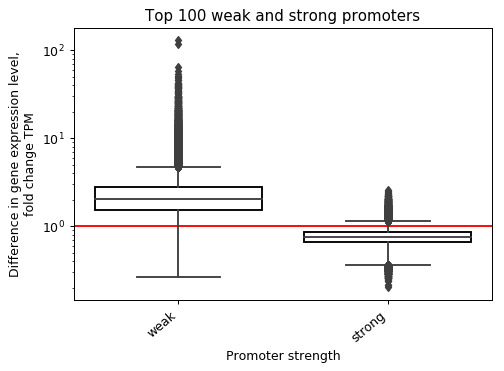

In [66]:
# median fold change

print(df_100[df_100.strength=='weak'].yfold_tpm.median())
print(1/df_100[df_100.strength=='strong'].yfold_tpm.median())

# statistical test
# compare Ranskum of distribution ynative vs ytpm
print(stats.ranksums(x=df_100[df_100.strength=='weak'].ynative,
             y=df_100[df_100.strength=='weak'].ytpm))
print(stats.ranksums(x=df_100[df_100.strength=='strong'].ynative,
             y=df_100[df_100.strength=='strong'].ytpm))

# plot

mpl.rcParams['figure.dpi'] = 90

ax = sns.boxplot(data=df_100,x='strength',y='yfold_tpm')
plt.plot([-1,2],[1,1],'r',zorder=0)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40,ha="right")
plt.yscale('log')
plt.title('Top 100 weak and strong promoters')
plt.xlabel('Promoter strength')
plt.ylabel('Difference in gene expression level,\nfold change TPM')

plt.show()

In [67]:
# Yamanishi 2013 data comparison

# point is to show our predicted ranges correspond 
# to experimentally measured ones
# basically a comparison of distributions and correlations

# this should be analysed further
# subset the genes in yama and ours
# compare native and gfp codons predictions with the relative FI

fi_median = 0.86
fi_max = 2.52
fi_min = 0.036

print(fi_max/fi_median, 1/(fi_min/fi_median), (fi_max/fi_median+1/(fi_min/fi_median))/2)
print(fi_max/fi_min)

df_yama = pd.read_csv(folder+fn8)
df_yama[df_yama.gene_name=='YGR192C'] # TDH3

df_yama['ytpm_native'] = (df_native[(df_native.gene_id_left=='YGR192C')&
                                    (df_native.gene_id_right.isin(df_yama.gene_name))]
                          .ytpm
                          .values
                         )
df_yama['fold_native'] = (df_native[(df_native.gene_id_left=='YGR192C')&
                                    (df_native.gene_id_right.isin(df_yama.gene_name))]
                          .yfold_tpm
                          .values
                         )
df_yama['fold_gfp'] = (df_yama
                        .ytpm_gfpt
                        .apply(lambda x: x/df_yama[df_yama.gene_name=='YGR192C'].ytpm_native.values[0])
                       )
df_yama['fold_fi'] = (df_yama
                        .relative_fi
                        .apply(lambda x: x/df_yama[df_yama.gene_name=='YGR192C'].relative_fi.values[0])
                       )

#plt.figure(figsize=(2,1.5))
#var.hist(bins = 100)
# bmin, bmax = 0.01, 10000
# logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
# plt.hist(df_yama.fold_native, bins = logbins,color='r', alpha=0.4)
# plt.hist(df_yama.fold_gfp, bins = logbins,color='b', alpha=0.4)
# plt.hist(df_yama['fold_fi'], bins = logbins,color='k',alpha=0.4)
# plt.xscale('log')
# #plt.xlim(0.1,10)
# plt.legend(['Predicted\nexpresion\nlevel, TPM', 'Measured\nfluorescence\nintensity'],
#           loc='upper left')
# plt.xlabel('Range of expression levels for TDH3, fold change')
# plt.ylabel('Counts')
# plt.show()

2.9302325581395348 23.88888888888889 13.409560723514211
70.0


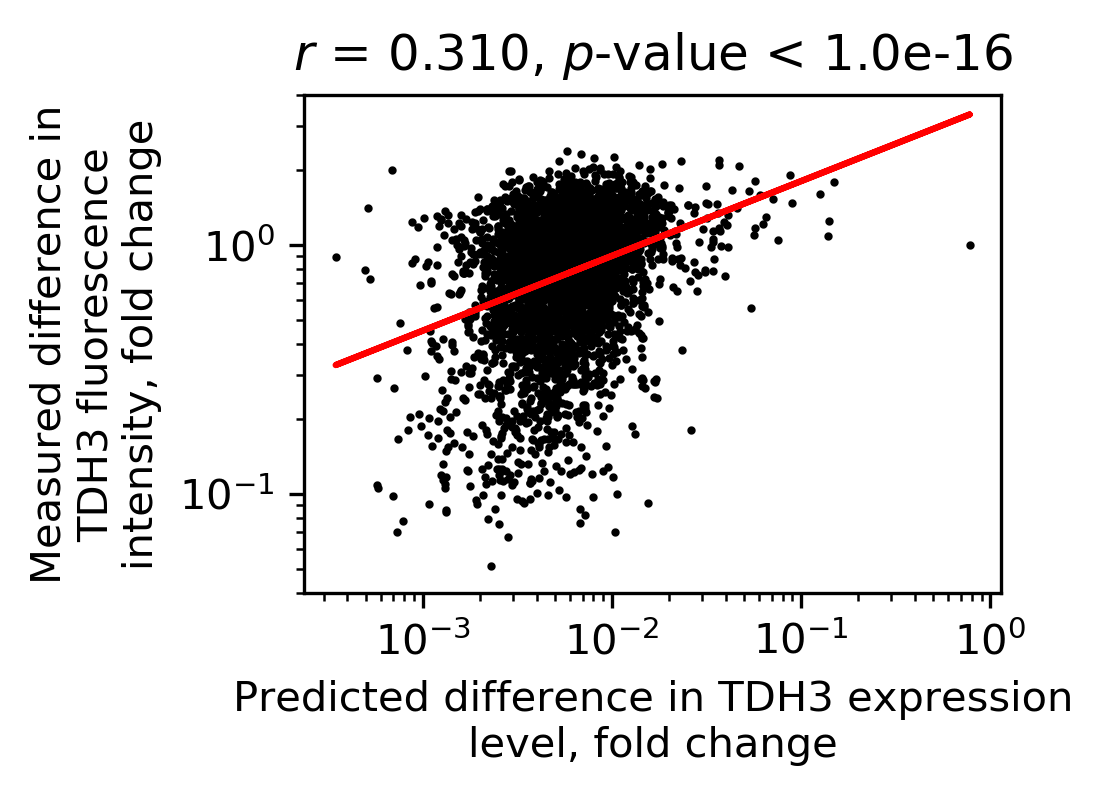

In [68]:
# scatter exp Yamanishi 2013

mpl.rcParams['figure.dpi'] = 300
#df_yama
plt.figure(figsize=(3,2.2))
x = df_yama.fold_gfp.values
y = df_yama.fold_fi.values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
plt.ylim(0.04,4)
plt.ylabel('Measured difference in\nTDH3 fluorescence\nintensity, fold change')
plt.xlabel('Predicted difference in TDH3 expression\nlevel, fold change')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

plt.savefig('f5d.svg')

# Native terminators - shuffled promoters

In [69]:
df_native = pd.read_csv(folder+fn1,sep=';')
df_native.head()

,gene_id_left,gene_id_right,ypred,ynative,ytpm,ynative_tpm,yfold,yfold_tpm
0,YOL097W-A,YLR312W-A,2.936,1.125977,9.628451,2.734563,2.607112,3.521020
1,YOL097W-A,YMR187C,2.473,1.125977,7.202242,2.734563,2.196010,2.633782
2,YOL097W-A,YER183C,2.758,1.125977,8.631579,2.734563,2.449263,3.156475
3,YOL097W-A,YFR022W,2.398,1.125977,6.862466,2.734563,2.130095,2.509529
4,YOL097W-A,YNL233W,3.469,1.125977,13.166449,2.734563,3.080659,4.814827


In [70]:
# mark all important points on figure

# check gene function
# wget file from sgd
# import wget
# url = 'https://downloads.yeastgenome.org/curation/chromosomal_feature/SGD_features.tab'
# fname = wget.download(url)

# columns = ['Primary SGDID (mandatory)',
#            'Feature type (mandatory)',
#             'Feature qualifier (optional)',
#             'Feature name',
#             'Standard gene name (optional)',
#             'Alias (optional, multiples separated by |)',
#             'Parent feature name (optional)',
#             'Secondary SGDID (optional, multiples separated by |)',
#             'Chromosome (optional)',
#             'Start_coordinate (optional)',
#             'Stop_coordinate (optional)',
#             'Strand (optional)',
#             'Genetic position (optional)',
#             'Coordinate version (optional)',
#             'Sequence version (optional)',
#             'Description']
# gene_function = pd.read_csv(folder+fn6,sep='\t',header=None,names=columns)
# gene_function.head()

# max range is same as max increase
max_range = (pd.DataFrame(df_native
                         .groupby('gene_id_left')
                         .yfold_tpm
                         .apply(lambda x: max(x)/min(x)))
             .reset_index()
             .rename(columns={'yfold_tpm':'max_range'})
            )
df_native = df_native.merge(max_range,on='gene_id_left',how='left')
print(df_native.max_range.max())
print(df_native[df_native.max_range==df_native.max_range.max()].gene_id_left.iloc[0])

# from gene to max point
# maximum increase
max_increase = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                .max().max()]
                .index.values[0])
print(df_native.loc[max_increase])

# get gene name
name_increase = (pd.DataFrame(df_native.loc[max_increase]).transpose()
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
).gene_id_left.values[0]
print(name_increase)

# max decrease
max_decrease = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                .min().min()]
                .index.values[0])
print(df_native.loc[max_decrease])

# get gene name
name_decrease = (pd.DataFrame(df_native.loc[max_decrease]).transpose()
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
)['Standard gene name (optional)'].values[0]
print(name_decrease)

# average on both sides
print((df_native.groupby('gene_id_left')['yfold_tpm']
 .max().median()+1/df_native.groupby('gene_id_left')['yfold_tpm']
                   .min().median())/2)


2120.1165627661735
YNL146W
gene_id_left     YOL097W-A
gene_id_right      YGR192C
ypred                25.12
ynative            1.12598
ytpm                5051.2
ynative_tpm        2.73456
yfold               22.314
yfold_tpm          1847.17
max_range          2077.98
Name: 1019, dtype: object
YOL097W-A
gene_id_left       YIL051C
gene_id_right      YOR378W
ypred                3.418
ynative            12.5781
ytpm               12.7915
ynative_tpm        415.203
yfold             0.271739
yfold_tpm        0.0308078
max_range           640.24
Name: 16597426, dtype: object
MMF1
20.971189511355536


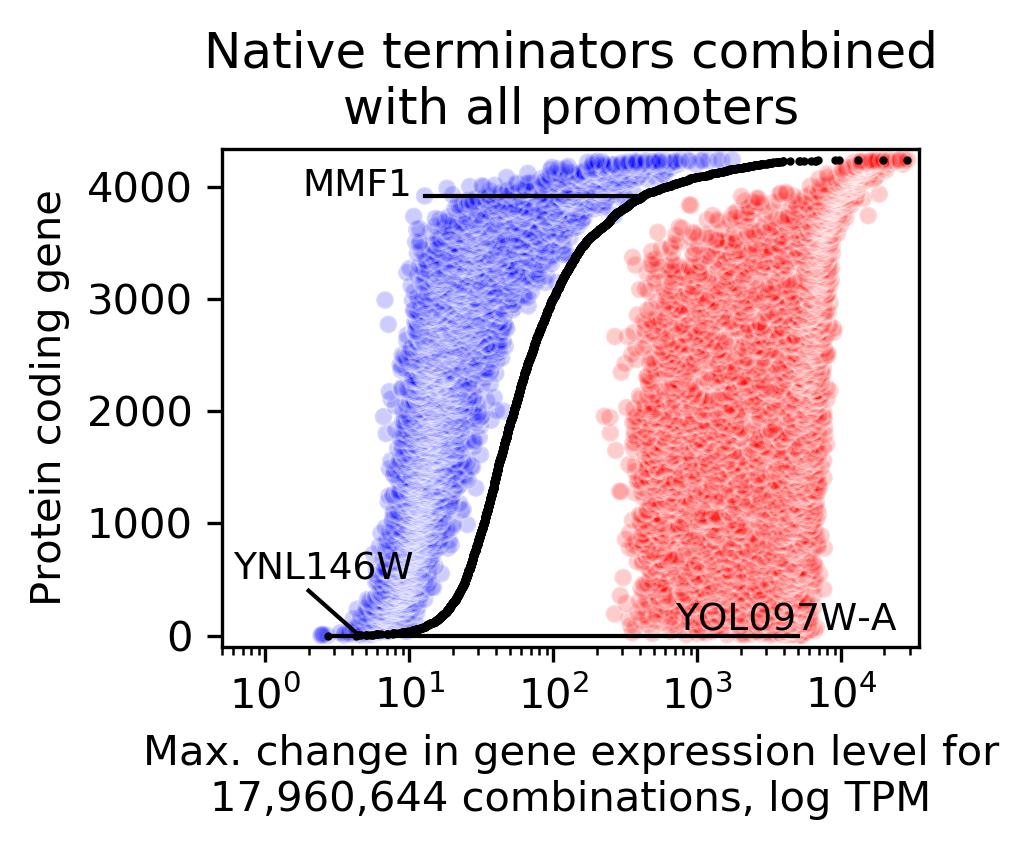

In [45]:
## Plot maximum values per gene

df_plot = (df_native
           .groupby('gene_id_left')['ytpm']
           .max()
           .reset_index()
           .rename(columns={'ytpm':'ytpm_max'})
          )
df_plot['ytpm_min'] = df_native.groupby('gene_id_left')['ytpm'].min().values
df_plot['ytpm'] = df_native.groupby('gene_id_left').ynative_tpm.mean().values
df_plot = df_plot.sort_values(by='ytpm')

df_plot.head()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))

plt.scatter(df_plot.ytpm,
            df_plot.gene_id_left,
            s=1,alpha=1,zorder=10, color='k')
#ax = sns.scatterplot(x='gene_id_left',y='ytpm',alpha=1,data=df_plot)
ax = sns.scatterplot(y='gene_id_left',x='ytpm_max',
                     size=1,alpha=0.2,data=df_plot,
                     color='r',legend=False)
ax = sns.scatterplot(y='gene_id_left',x='ytpm_min',
                     size=1,alpha=0.2,data=df_plot,
                     color='b',legend=False)
plt.title('Native terminators combined\nwith all promoters')
plt.xscale('log')
plt.yticks(ticks=[0,1000,2000,3000,4000],labels=[0,1000,2000,3000,4000])
#plt.xlim(1e0,1e4)
plt.xlim(1-1/2,35000)
plt.ylim(-100,len(gene_names)+100)
plt.xlabel('Max. change in gene expression level for\n17,960,644 combinations, log TPM')
plt.ylabel('Protein coding gene')
#plt.legend(['native_level', 'max increase', 'max decrease'],loc='upper left')

# mark stuff
# from gene to max point
# maximum increase
index = int(np.floor(max_increase/df_native.gene_id_left.unique().shape[0]))
plt.plot([df_native.loc[max_increase].ynative_tpm,
         df_native.loc[max_increase].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_increase,xy=(700,index+50),fontsize=9)

index = int(np.floor(max_decrease/df_native.gene_id_left.unique().shape[0]))
plt.plot([df_native.loc[max_decrease].ynative_tpm,
         df_native.loc[max_decrease].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_decrease,xy=(1.8,index),fontsize=9)

# max range - unclear so revert to just indicating gene
max_range = df_native[df_native.max_range==df_native.max_range.max()]
index = int(np.floor(max_range.index[0]/df_native.gene_id_left.unique().shape[0]))
# plt.plot([max_range.ytpm.min(),max_range.ytpm.max()],
#          [index,index],'k',linewidth=1)
plt.annotate(max_range.gene_id_left.values[0],xy=(0.6,index+500),fontsize=9)
plt.plot([2,max_range.ynative_tpm.max()],
         [400,index],'k',linewidth=1)

plt.savefig('f5e.svg')

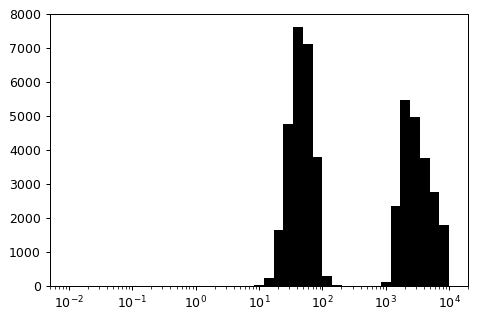

In [71]:
# distribution of predicted native y

mpl.rcParams['figure.dpi'] = 90
#plt.figure(figsize=(2,1.5))
#var.hist(bins = 100)
bmin, bmax = 0.01, 10000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(df_plot.ytpm, bins = logbins,color='k')
plt.xscale('log')
plt.show()

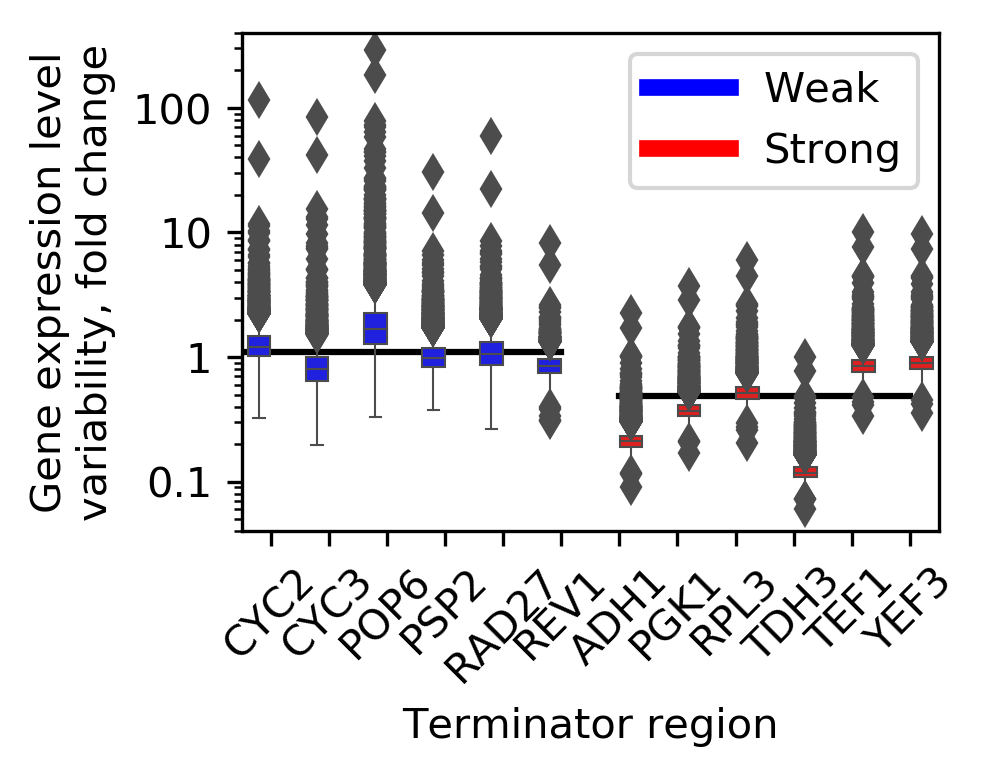

In [72]:
# Strong and weak promoter subsets

## analyse known genes changes
df_plot = (df_native[df_native.gene_id_left.isin(df_known.gene_id)]
           .merge(df_known,left_on='gene_id_left',right_on='gene_id')
          )

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))

sns.boxplot(x='gene_name',y='yfold_tpm',data=df_plot,
            hue='strength',palette=['b','r'],
            order=df_plot.sort_values(by=['strength','gene_name'],ascending=[False,True])
            .gene_name.unique(),
           linewidth=0.5)
ann = df_plot.groupby(['strength','gene_name']).yfold_tpm.median().loc['weak'].mean()
plt.plot([-0.5,5],[ann,ann],'k',zorder=0)
ann = df_plot.groupby(['strength','gene_name']).yfold_tpm.median().loc['strong'].mean()
plt.plot([6,11],[ann,ann],'k',zorder=0)
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('Gene expression level\nvariability, fold change')
plt.xlabel('Terminator region')
plt.ylim(0.04,400)
plt.yticks(ticks=[0.1,1,10,100],labels=['0.1','1','10','100'])

# legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
plt.legend(custom_lines, ['Weak',
                         'Strong'])

plt.savefig('f5f.svg')

In [73]:
# Top 100 Bottom 100

tmp = df_native.sort_values(by='ynative_tpm').iloc[:100*4238]
tmp['strength'] = 'weak'
tmp['region'] = 'terminator'
df_100 = df_100.append(tmp)
# sanity check
# tmp.groupby('gene_id_left').gene_id_right.count().describe()
print(df_100.shape)

tmp = df_native.sort_values(by='ynative_tpm').iloc[-100*4238:]
tmp['strength'] = 'strong'
tmp['region'] = 'terminator'
# sanity check
# tmp.groupby('gene_id_left').gene_id_right.count().describe()

df_100 = df_100.append(tmp)
print(df_100.shape)

(1271400, 11)
(1695200, 11)


2.2588487
2.4309656797237724
RanksumsResult(statistic=-797.2326233592715, pvalue=0.0)
RanksumsResult(statistic=-797.3075002788353, pvalue=0.0)


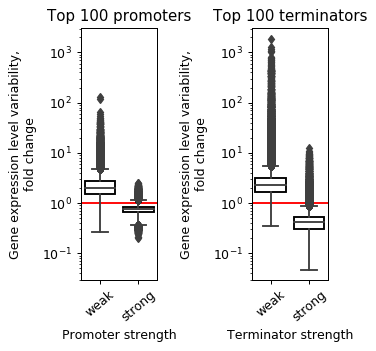

In [74]:
# median fold change

print(df_100[(df_100.strength=='weak')&
             (df_100.region=='terminator')].yfold_tpm.median())
print(1/df_100[(df_100.strength=='strong')&
             (df_100.region=='terminator')].yfold_tpm.median())

# statistical test
# compare Ranskum of distribution ynative vs ytpm
print(stats.ranksums(x=df_100[(df_100.strength=='weak')&
             (df_100.region=='terminator')].ynative,
             y=df_100[(df_100.strength=='weak')&
             (df_100.region=='terminator')].ytpm))
print(stats.ranksums(x=df_100[(df_100.strength=='strong')&
             (df_100.region=='terminator')].ynative,
             y=df_100[(df_100.strength=='strong')&
             (df_100.region=='terminator')].ytpm))

# plot
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,4))

plt.subplot(1,2,1)
ax = sns.boxplot(data=df_100[df_100.region=='promoter'],
                 x='strength',y='yfold_tpm')
plt.plot([-1,2],[1,1],'r',zorder=0)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40)#,ha="right")
plt.yscale('log')
plt.ylim(0.03,3000)
plt.title('Top 100 promoters')
plt.xlabel('Promoter strength')
plt.ylabel('Gene expression level variability,\nfold change')

plt.subplot(1,2,2)
ax = sns.boxplot(data=df_100[df_100.region=='terminator'],
                 x='strength',y='yfold_tpm')
plt.plot([-1,2],[1,1],'r',zorder=0)
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')
plt.xticks(rotation=40)#,ha="right")
plt.yscale('log')
plt.ylim(0.03,3000)
plt.title('Top 100 terminators')
plt.xlabel('Terminator strength')
plt.ylabel('Gene expression level variability,\nfold change')

plt.tight_layout()
plt.show()

In [75]:
# Keren 2013 data comparison

df_keren = pd.read_csv(folder+fn7)
df_keren[df_keren.Alias_x=='ADH1']

df_keren['ytpm_native'] = (df_native[(df_native.gene_id_left=='YOL086C')&
                                    (df_native.gene_id_right.isin(df_keren.ORF))]
                          .ytpm
                          .values
                         )
df_keren['fold_native'] = (df_native[(df_native.gene_id_left=='YOL086C')&
                                    (df_native.gene_id_right.isin(df_keren.ORF))]
                          .yfold_tpm
                          .values
                         )
df_keren['fold_gfp'] = (df_keren
                        .ytpm
                        .apply(lambda x: x/df_keren[df_keren.ORF=='YOL086C'].ytpm.values[0])
                       )
df_keren['fold_fi'] = (df_keren['median']
                        .apply(lambda x: x/df_keren[df_keren.ORF=='YOL086C']['median'].values[0])
                       )

# #plt.figure(figsize=(2,1.5))
# #var.hist(bins = 100)
# bmin, bmax = 0.01, 10000
# logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
# plt.hist(df_keren.fold_native, bins = logbins,color='r', alpha=0.4)
# plt.hist(df_keren.fold_gfp, bins = logbins,color='b', alpha=0.4)
# plt.hist(df_keren['fold_fi'], bins = logbins,color='k',alpha=0.4)
# plt.xscale('log')
# #plt.xlim(0.1,10)
# plt.legend(['Predicted\nexpresion\nlevel, TPM', 'Measured\nfluorescence\nintensity'],
#           loc='upper left')
# plt.xlabel('Range of expression levels for TDH3, fold change')
# plt.ylabel('Counts')
# plt.show()

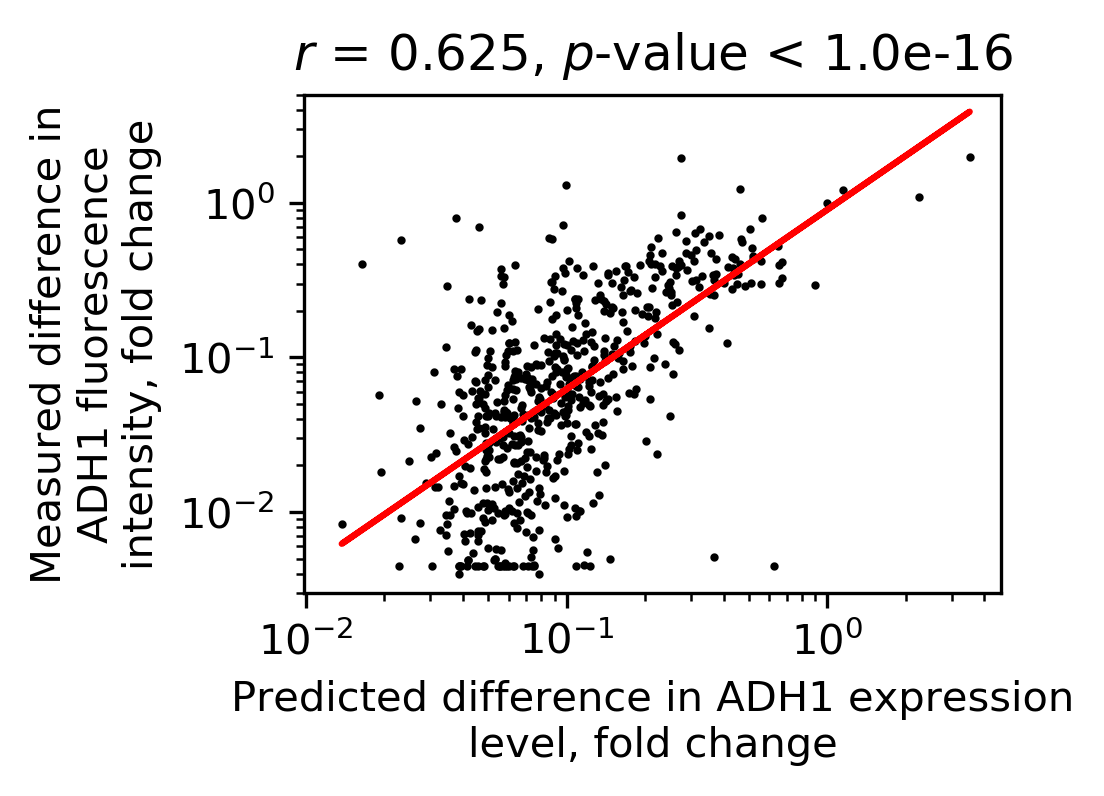

In [76]:
# Keren

mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=(3,2.2))
x = df_keren.fold_gfp.values
y = df_keren.fold_fi.values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
plt.ylim(0.003,5)
plt.ylabel('Measured difference in\nADH1 fluorescence\nintensity, fold change')
plt.xlabel('Predicted difference in ADH1 expression\nlevel, fold change')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

plt.savefig('f5g.svg')

# Random shuffling controls

In [52]:
df_pr = pd.read_csv(folder+fn00,sep=';')
df_rn = pd.read_csv(folder+fn2,sep=';')
df_rs = pd.read_csv(folder+fn3,sep=';')

df_rs.head()


,gene_id_left,gene_id_right,ypred,ynative,ytpm,ynative_tpm,yfold,yfold_tpm
0,YPR146C,YLL034C,3.849400,2.748586,16.258186,8.582123,1.400502,1.894425
1,YPR146C,YMR092C,3.010846,2.748586,10.076896,8.582123,1.095416,1.174173
2,YPR146C,YMR262W,3.121083,2.748586,10.762620,8.582123,1.135523,1.254074
3,YPR146C,YJR144W,3.221068,2.748586,11.415550,8.582123,1.171900,1.330155
4,YPR146C,YOR304C-A,2.734369,2.748586,8.506353,8.582123,0.994828,0.991171


In [53]:
# compare ranges

# average on both sides
tmp_pr = ((df_pr.groupby('gene_id_left')['yfold_tpm']
 .max().median()+1/df_pr.groupby('gene_id_left')['yfold_tpm']
                   .min().median())/2)

tmp_rn = ((df_rn.groupby('gene_id_left')['yfold_tpm']
 .max().median()+1/df_rn.groupby('gene_id_left')['yfold_tpm']
                   .min().median())/2)

# tmp_rs = ((df_rs.groupby('gene_id_left')['yfold_tpm']
#  .max().median()+1/df_rs.groupby('gene_id_left')['yfold_tpm']
#                    .min().median())/2)

print(tmp_pr/tmp_rn)
print(tmp_rn)

# maximum increase
print(df_rn[df_rn.yfold_tpm==df_rn.groupby('gene_id_left')['yfold_tpm'].max().max()]
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
)

# maximum decrease
print(df_rn[df_rn.yfold_tpm==df_rn.groupby('gene_id_left')['yfold_tpm'].min().min()]
 .merge(gene_function.loc[:,['Feature name',
                             'Standard gene name (optional)','Description']],
       left_on='gene_id_left',right_on='Feature name',how='left')
)

# groupby and measure range of changes for all genes
tmp_pr = df_pr.groupby('gene_id_left').yfold_tpm.apply(lambda x: max(x)/min(x)).max()
tmp_rn = df_rn.groupby('gene_id_left').yfold_tpm.apply(lambda x: max(x)/min(x)).max()

print(tmp_pr/tmp_rn)
print(tmp_rn)


1.87519831137915
1.422721269083937
  gene_id_left   gene_id_right     ypred   ynative      ytpm  ynative_tpm  \
0    YIL102C-A  YIL102C-A_r327  7.514912  3.972516  84.38926     17.37052   

      yfold  yfold_tpm Feature name Standard gene name (optional)  \
0  1.891726   4.858189    YIL102C-A                           NaN   

                                         Description  
0  Putative protein of unknown function; identifi...  
  gene_id_left gene_id_right      ypred    ynative       ytpm  ynative_tpm  \
0      YPR149W  YPR149W_r455  10.058117  14.382162  201.37614   654.626664   

      yfold  yfold_tpm Feature name Standard gene name (optional)  \
0  0.699347    0.30762      YPR149W                        NCE102   

                                         Description  
0  Protein of unknown function; contains transmem...  
13.532871030757029
6.318721108194286


In [54]:
# max range is same as max increase
max_range = (pd.DataFrame(df_rn
                         .groupby('gene_id_left')
                         .yfold_tpm
                         .apply(lambda x: max(x)/min(x)))
             .reset_index()
             .rename(columns={'yfold_tpm':'max_range'})
            )
df_rn = df_rn.merge(max_range,on='gene_id_left',how='left')
print(df_rn.max_range.max())
print(df_rn[df_rn.max_range==df_rn.max_range.max()].gene_id_left.iloc[0])

6.318721108194286
YIL102C-A


In [55]:
# significance tests

tmp = []
for gene in df_pr.gene_id_left.unique():
    x = df_pr[df_pr.gene_id_left==gene].ytpm.values
    y = df_rn[df_rn.gene_id_left==gene].ytpm.values
    tmp.append(stats.levene(x,y)[1])
    
print(min(tmp))
# just over all
print(stats.levene(df_pr.ytpm.values,df_rn.ytpm.values)[1])
# all below 1e-16


1.62371067891245e-128
8.330225758082165e-33


In [56]:
# mark all important points on figure

def get_vals_plot(df_native):
    # from gene to max point
    # maximum increase
    max_increase = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                    .max().max()]
                    .index.values[0])
    print(df_native.loc[max_increase])

    # get gene name
    name_increase = (pd.DataFrame(df_native.loc[max_increase]).transpose()
     .merge(gene_function.loc[:,['Feature name',
                                 'Standard gene name (optional)','Description']],
           left_on='gene_id_left',right_on='Feature name',how='left')
    ).gene_id_left.values[0]
    print(name_increase)

    # max decrease
    max_decrease = (df_native[df_native.yfold_tpm==df_native.groupby('gene_id_left')['yfold_tpm']
                    .min().min()]
                    .index.values[0])
    print(df_native.loc[max_decrease])

    # get gene name
    name_decrease = (pd.DataFrame(df_native.loc[max_decrease]).transpose()
     .merge(gene_function.loc[:,['Feature name',
                                 'Standard gene name (optional)','Description']],
           left_on='gene_id_left',right_on='Feature name',how='left')
    )['Standard gene name (optional)'].values[0]
    print(name_decrease)
    return max_increase, name_increase, max_decrease, name_decrease

max_increase, name_increase, max_decrease, name_decrease = get_vals_plot(df_rn)
    

gene_id_left          YIL102C-A
gene_id_right    YIL102C-A_r327
ypred                   7.51491
ynative                 3.97252
ytpm                    84.3893
ynative_tpm             17.3705
yfold                   1.89173
yfold_tpm               4.85819
max_range               6.31872
Name: 48413, dtype: object
YIL102C-A
gene_id_left          YPR149W
gene_id_right    YPR149W_r455
ypred                 10.0581
ynative               14.3822
ytpm                  201.376
ynative_tpm           654.627
yfold                0.699347
yfold_tpm             0.30762
max_range             4.43555
Name: 946298, dtype: object
NCE102


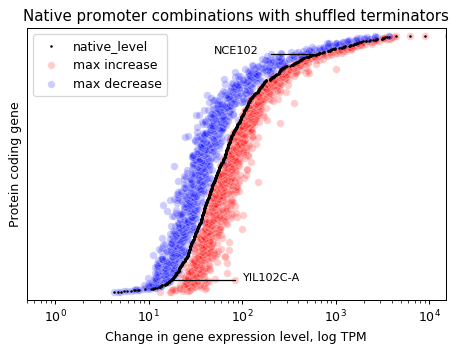

In [57]:
# plot supplementary

mpl.rcParams['figure.dpi'] = 90

## Plot maximum values per gene

df_plot = (df_rn
           .groupby('gene_id_left')['ytpm']
           .max()
           .reset_index()
           .rename(columns={'ytpm':'ytpm_max'})
          )
df_plot['ytpm_min'] = df_rn.groupby('gene_id_left')['ytpm'].min().values
df_plot['ytpm'] = df_rn.groupby('gene_id_left').ynative_tpm.mean().values
df_plot = df_plot.sort_values(by='ytpm')

df_plot.head()

plt.scatter(df_plot.ytpm,
            df_plot.gene_id_left,
            s=1,alpha=1,zorder=10, color='k')
#ax = sns.scatterplot(x='gene_id_left',y='ytpm',alpha=1,data=df_plot)
ax = sns.scatterplot(y='gene_id_left',x='ytpm_max',alpha=0.2,data=df_plot,color='r')
ax = sns.scatterplot(y='gene_id_left',x='ytpm_min',alpha=0.2,data=df_plot,color='b')
plt.title('Native promoter combinations with shuffled terminators')
plt.xscale('log')
plt.yticks([])
#plt.xlim(1e0,1e4)
plt.xlim(1-1/2,10000+10000/2)
plt.ylim(-30,df_rn.gene_id_left.unique().shape[0]+30)
plt.xlabel('Change in gene expression level, log TPM')
plt.ylabel('Protein coding gene')
plt.legend(['native_level', 'max increase', 'max decrease'])

# mark all important points on figure
# maximum increase
index = int(np.floor(max_increase/df_rn.gene_id_left.unique().shape[0]))
plt.plot([df_rn.loc[max_increase].ynative_tpm,
         df_rn.loc[max_increase].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_increase,xy=(100,index),fontsize=9)

index = int(np.floor(max_decrease/df_rn.gene_id_left.unique().shape[0]))
plt.plot([df_rn.loc[max_decrease].ynative_tpm,
         df_rn.loc[max_decrease].ytpm],
         [index,index],'k',linewidth=1)
plt.annotate(name_decrease,xy=(50,index),fontsize=9)

plt.show()


In [58]:
# check standard names for genes mentioned

genes = ['YOL097W-A',
         'YGR192C',
         'YHR005C-A',
         'YLR234W',
         'YGR192C'
         'YNL146W',
         'YIL051C',
         'YOR378W',
         'YIL102C-A',
         'YPR149W']

gene_function.loc[gene_function['Feature name'].isin(genes),
                  ['Feature name','Standard gene name (optional)','Description']]



,Feature name,Standard gene name (optional),Description
2940,YLR234W,TOP3,DNA Topoisomerase III; conserved protein that ...
6051,YOL097W-A,NaN,Putative protein of unknown function; identifi...
7224,YOR378W,AMF1,Low affinity NH4+ transporter; member of the D...
8351,YPR149W,NCE102,Protein of unknown function; contains transmem...
14753,YGR192C,TDH3,Glyceraldehyde-3-phosphate dehydrogenase (GAPD...
15169,YHR005C-A,TIM10,Essential protein of the mitochondrial interme...
15984,YIL102C-A,NaN,Putative protein of unknown function; identifi...
16127,YIL051C,MMF1,Mitochondrial protein required for transaminat...
